In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from statistics import mean
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from impyute.imputation import cs

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [2]:
def exp_output(array):
    return ['%.5Ef' % x for x in array]

In [3]:
def get_metrics(y_test, y_pred, X_cols=235):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adj_r_squared = 1 - (1-r_squared)*(len(y_test) - 1)/(len(y_test) - X_cols -1)
    return  {
        'mape': sum(abs((y_test - y_pred)/y_test)),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'mse': metrics.mean_squared_error(y_test, y_pred),
#         'msle': metrics.mean_squared_log_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'r2': metrics.r2_score(y_test, y_pred),
        '_r_squared': r_squared,
        '_adj_r_squared': adj_r_squared,
    }

def print_metrics(y_test, y_pred):
    res = get_metrics(y_test, y_pred)
    for key in res:
        print(f'{key}: {res[key]}')
    return res

In [4]:
df = pd.read_csv('16 df_gender.csv')

In [5]:
list(df.columns)

['budget',
 'META__id',
 'PROCESS__original_language',
 'runtime',
 'spoken_languages',
 'META__year',
 'META__month',
 'META__day',
 'weekend',
 'META__collection_name',
 'META__cast_1_name',
 'META__cast_2_name',
 'META__cast_3_name',
 'META__cast_4_name',
 'META__cast_5_name',
 'META__cast_6_name',
 'META__cast_7_name',
 'META__cast_8_name',
 'META__crew__sound__music_editor',
 'META__crew__sound__original_music_composer',
 'META__crew__sound__sound_designer',
 'META__crew__sound__sound_effects_editor',
 'META__crew__sound__sound_re_recording_mixer',
 'META__crew__sound__supervising_sound_editor',
 'META__crew__directing__director__1',
 'META__crew__directing__script_supervisor',
 'META__crew__production__casting',
 'META__crew__production__executive_producer__1',
 'META__crew__production__producer__1',
 'META__crew__production__producer__2',
 'META__crew__editing__editor__1',
 'META__crew__costume__costume_designer',
 'META__crew__costume__costume_supervisor',
 'META__crew__costume

In [6]:
shuffled_df = shuffle(df, random_state=0)

In [7]:
num_in_train = int(shuffled_df.shape[0]*0.8)

In [8]:
df_train = shuffled_df[:num_in_train]
df_test = shuffled_df[num_in_train:]

In [9]:
def get_train_test_profitability(df):
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col]]
    X = dff.drop('profitability', axis=1)
    y = dff['profitability']
    return X, y

In [10]:
def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col]]
    X = dff.drop(['revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [11]:
# X_train, y_train = get_train_test_profitability(df_train)
# X_test, y_test = get_train_test_profitability(df_test)
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
class Process:
    def __init__(self, X_train, X_test, y_train, y_test, imputer='mean', minmaxrange=(0,1)):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange).fit(self.X_train)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange).fit(self.y_train)
        
    def fill_nan(self):
        def fill_train_test(imputer):
#             self.X_train[:] = imputer.fit_transform(self.X_train)
#             self.X_test[:] = imputer.fit_transform(self.X_test)
            self.X_train[:] = imputer(self.X_train.to_numpy(dtype=float))
            self.X_test[:] = imputer(self.X_test.to_numpy(dtype=float))
            
#         if (self.imputer == 'mean'):
#             fill_train_test(SimpleImputer(strategy='mean'))
#         elif (self.imputer == 'median'):
#             fill_train_test(SimpleImputer(strategy='median'))
#         elif (self.imputer == 'knn'):
#             fill_train_test(KNNImputer())
#         elif (self.imputer == 'iterative'):
#             fill_train_test(IterativeImputer(verbose=2, max_iter=20))
#         elif (self.imputer == 'iterative_mlp'):
#             fill_train_test(
#                 IterativeImputer(
#                     estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
#                     verbose=2,
#                 )
#             )
        
        if (self.imputer == 'mean'):
            fill_train_test(cs.mean)
        elif (self.imputer == 'median'):
            fill_train_test(cs.median)
        elif (self.imputer == 'mode'):
            fill_train_test(cs.mode)
        elif (self.imputer == 'em'):
            fill_train_test(cs.em)
        elif (self.imputer == 'fast_knn'):
            fill_train_test(cs.fast_knn)
        return self
        
    def minmaxscaleX(self):
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        return self
        
    def minmaxscaleY(self):
        self.y_train = self.y_minmaxscaler.transform(self.y_train)
        self.y_test = self.y_minmaxscaler.transform(self.y_test)
        return self

    def inverse_X_minmaxscale(self, obj):
        return self.X_minmaxscaler.inverse_transform(obj)
    
    def inverse_y_minmaxscaler(self, obj):
        return self.y_minmaxscaler.inverse_transform(obj.reshape(-1, 1)).flatten()
    
    def make_target_positive(self):
        self.min_y_train = min(self.y_train)
        self.y_train = self.y_train - self.min_y_train + 1
        self.y_test = self.y_test - self.min_y_train + 1
        return self
        
    def return_target_back_from_positive(self):
        self.y_train = self.y_train + self.min_y_train - 1
        self.y_test = self.y_test + self.min_y_train - 1
        return self
    
    def return_target_back_from_positive(self, obj):
        return obj + self.min_y_train - 1
    
    def fix_skew(self, function='log'):
        if function == 'log':
            self.y_train = np.log(self.y_train)
            self.y_test = np.log(self.y_test)
        return self
            
    def inverse_skew(self, function='log'):
        if function == 'log':
            self.y_train = np.exp(self.y_train)
            self.y_test = np.ext(self.y_test)
        return self
    
    def return_processed(self):
        return self.X_train, self.X_test, self.y_train.flatten(), self.y_test.flatten()       

In [99]:
imputer = 'median'

nan_filled_test_train = {}
nan_filled_test_train[imputer] = {}
process = Process(X_train, X_test, y_train, y_test, imputer=imputer).minmaxscaleX().fill_nan()
train, test, _, _ = process.return_processed()
print('processed')
nan_filled_test_train[imputer]['train'] = train
nan_filled_test_train[imputer]['test'] = test
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()

processed


In [107]:
results = {}
for imputer in [
    'mean',
    'median',
    'knn',
    'iterative',
#     'iterative_mlp',
#     
#     'mean',
#     'median',
#     'mode',
#     'em',
#     'fast_knn',
]:
#     print(imputer)
#     nan_filled_test_train[imputer] = {}
#     process = Process(X_train, X_test, y_train, y_test, imputer=imputer).minmaxscaleX().fill_nan()
#     train, test, _, _ = process.return_processed()
#     print('processed')
#     nan_filled_test_train[imputer]['train'] = train
#     nan_filled_test_train[imputer]['test'] = test
#     Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
    
    mlp = MLPRegressor(
#         solver='adam',
        hidden_layer_sizes=(100,100,100),
#         activation='relu',
#         learning_rate='adaptive',
#         early_stopping=True,
        random_state=0,
        max_iter=1000,
#         tol=0.00001,
        verbose=True)

    # not scaled y
    print("training")
    mlp.fit(Xh_train, yh_train)
    predicted_y = mlp.predict(Xh_test)
    results[imputer] = {}
    results[imputer]['metrics'] = get_metrics(yh_test, predicted_y)
    results[imputer]['sample'] = pd.DataFrame({'actual':yh_test, 'predicted': predicted_y}).astype(int)

from pprint import pprint
for result in results:    
    print("-----------------------------------------")
    print(result)
    pprint(results[result]['metrics'])
    pprint(results[result]['sample'].head(30))

training
Iteration 1, loss = 17153506670311728.00000000
Iteration 2, loss = 17153499341600044.00000000
Iteration 3, loss = 17153433680295524.00000000
Iteration 4, loss = 17153125031280288.00000000
Iteration 5, loss = 17152196948327608.00000000
Iteration 6, loss = 17150051383376868.00000000
Iteration 7, loss = 17145831625133778.00000000
Iteration 8, loss = 17138530885933760.00000000
Iteration 9, loss = 17126746767540550.00000000
Iteration 10, loss = 17108822731887636.00000000
Iteration 11, loss = 17083288292493368.00000000
Iteration 12, loss = 17047796218671440.00000000
Iteration 13, loss = 17001279228645466.00000000
Iteration 14, loss = 16941834772459610.00000000
Iteration 15, loss = 16866978657543034.00000000
Iteration 16, loss = 16775584447875008.00000000
Iteration 17, loss = 16665250139779576.00000000
Iteration 18, loss = 16536090113644692.00000000
Iteration 19, loss = 16385980335863666.00000000
Iteration 20, loss = 16214146617965934.00000000
Iteration 21, loss = 16024063472021956.0

Iteration 174, loss = 7278865725045051.00000000
Iteration 175, loss = 7251068651834384.00000000
Iteration 176, loss = 7224338530473798.00000000
Iteration 177, loss = 7196599992934601.00000000
Iteration 178, loss = 7169252295056357.00000000
Iteration 179, loss = 7143034109941911.00000000
Iteration 180, loss = 7114736803311022.00000000
Iteration 181, loss = 7090255132911817.00000000
Iteration 182, loss = 7061616724576159.00000000
Iteration 183, loss = 7033985619586750.00000000
Iteration 184, loss = 7006377557821289.00000000
Iteration 185, loss = 6979184787041776.00000000
Iteration 186, loss = 6952024379161292.00000000
Iteration 187, loss = 6925088774912359.00000000
Iteration 188, loss = 6898267511629859.00000000
Iteration 189, loss = 6871334934007168.00000000
Iteration 190, loss = 6842193297700913.00000000
Iteration 191, loss = 6816434630714779.00000000
Iteration 192, loss = 6788952850304186.00000000
Iteration 193, loss = 6762077952684873.00000000
Iteration 194, loss = 6735629685696421.0

Iteration 346, loss = 4646132535903842.00000000
Iteration 347, loss = 4640263770132677.00000000
Iteration 348, loss = 4635724786832713.00000000
Iteration 349, loss = 4629185911387110.00000000
Iteration 350, loss = 4626175165817312.00000000
Iteration 351, loss = 4621881703352281.00000000
Iteration 352, loss = 4615719740379052.00000000
Iteration 353, loss = 4609194794897603.00000000
Iteration 354, loss = 4604658804003903.00000000
Iteration 355, loss = 4599918513343398.00000000
Iteration 356, loss = 4594986917280831.00000000
Iteration 357, loss = 4589926917812734.00000000
Iteration 358, loss = 4586388071388191.00000000
Iteration 359, loss = 4579797876247636.00000000
Iteration 360, loss = 4576147320810161.00000000
Iteration 361, loss = 4570512616171504.00000000
Iteration 362, loss = 4565961910532514.00000000
Iteration 363, loss = 4563007012210388.00000000
Iteration 364, loss = 4557360404644054.00000000
Iteration 365, loss = 4552753712533138.00000000
Iteration 366, loss = 4547605974442061.0

Iteration 517, loss = 4081517659273301.00000000
Iteration 518, loss = 4079313341721870.50000000
Iteration 519, loss = 4076850978073054.50000000
Iteration 520, loss = 4074976262484275.50000000
Iteration 521, loss = 4074858284609731.50000000
Iteration 522, loss = 4070022045216909.50000000
Iteration 523, loss = 4067519628258138.00000000
Iteration 524, loss = 4066889102119133.50000000
Iteration 525, loss = 4063529685788063.00000000
Iteration 526, loss = 4061941606151686.00000000
Iteration 527, loss = 4058917360866726.50000000
Iteration 528, loss = 4058644695309322.00000000
Iteration 529, loss = 4055396683778936.00000000
Iteration 530, loss = 4052285227459898.00000000
Iteration 531, loss = 4051082548955651.50000000
Iteration 532, loss = 4048890519546141.50000000
Iteration 533, loss = 4046970280662882.00000000
Iteration 534, loss = 4045060073615862.00000000
Iteration 535, loss = 4042296366207848.50000000
Iteration 536, loss = 4040716567613702.50000000
Iteration 537, loss = 4039321904065635.5

Iteration 688, loss = 3766861114883671.00000000
Iteration 689, loss = 3764253513996135.50000000
Iteration 690, loss = 3762668113060352.50000000
Iteration 691, loss = 3761353771874145.00000000
Iteration 692, loss = 3759789485357931.50000000
Iteration 693, loss = 3757935454658612.00000000
Iteration 694, loss = 3756169634138898.00000000
Iteration 695, loss = 3755500592162165.00000000
Iteration 696, loss = 3754290782565851.50000000
Iteration 697, loss = 3752611690608927.50000000
Iteration 698, loss = 3751101462726787.00000000
Iteration 699, loss = 3749217831502430.00000000
Iteration 700, loss = 3747566394058785.00000000
Iteration 701, loss = 3746141816349451.50000000
Iteration 702, loss = 3745022589225793.00000000
Iteration 703, loss = 3742714213994447.50000000
Iteration 704, loss = 3741708716394081.50000000
Iteration 705, loss = 3740320938811815.00000000
Iteration 706, loss = 3738416583369659.00000000
Iteration 707, loss = 3737142036793848.00000000
Iteration 708, loss = 3736721411805910.5

Iteration 859, loss = 3544787181405284.00000000
Iteration 860, loss = 3545987896146970.50000000
Iteration 861, loss = 3542730818237789.50000000
Iteration 862, loss = 3541471793174614.50000000
Iteration 863, loss = 3539824332908131.50000000
Iteration 864, loss = 3538698319140058.00000000
Iteration 865, loss = 3538720238095362.00000000
Iteration 866, loss = 3538884681760673.00000000
Iteration 867, loss = 3535418259454933.50000000
Iteration 868, loss = 3535337402296069.00000000
Iteration 869, loss = 3534248642809273.00000000
Iteration 870, loss = 3532430435075114.00000000
Iteration 871, loss = 3531171733928375.00000000
Iteration 872, loss = 3530357463913215.50000000
Iteration 873, loss = 3529829673292600.00000000
Iteration 874, loss = 3528517019629705.50000000
Iteration 875, loss = 3528522016583801.50000000
Iteration 876, loss = 3525463711551928.00000000
Iteration 877, loss = 3525759448098669.00000000
Iteration 878, loss = 3524045437056154.00000000
Iteration 879, loss = 3522863691046544.5

/home/stas/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [108]:
asc_df_res = results['median']['sample'].copy()
asc_df_res.sort_values(by='actual', inplace=True)

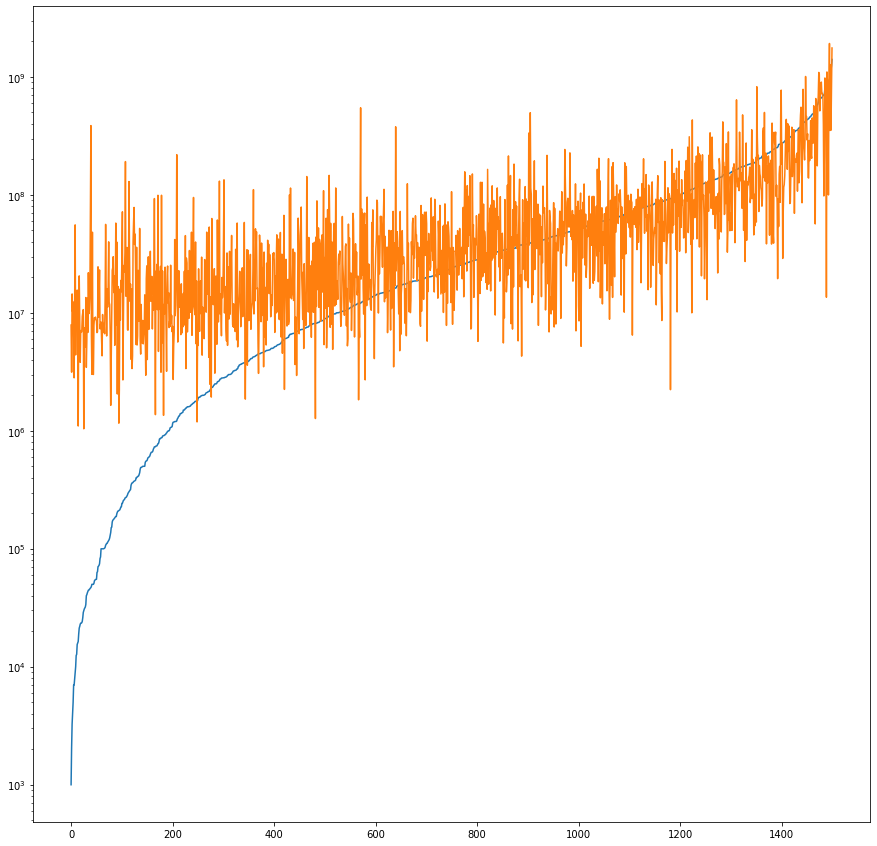

In [109]:
plt.clf()
x = np.linspace(0, len(asc_df_res['actual']), len(asc_df_res['actual']))
plt.plot(x, asc_df_res['actual'], label='actual')
plt.plot(x, asc_df_res['predicted'], label='predicted')

plt.ticklabel_format(useOffset=False, style='plain')
plt.rcParams["figure.figsize"] = (15,15)
plt.yscale('log')
plt.show()

In [ ]:
mlp.loss_curve_

In [ ]:
mlp.validation_scores_

In [ ]:
mean
{'metrics': {'mae': 19.08195794973531,
             'mse': 112199.24680258872,
             'rmse': 334.9615601865216},
 'sample':           actual  predicted
0      10.260719  -6.108725
1      22.314286   6.360902
2       6.169090  -2.005123
3       2.228443   0.877343
4      -2.077948  -0.679490
5   12889.386667  14.536277
6       2.858792   3.381179
7       7.021390   8.701726
8       2.422543  -0.846036
9      -1.208718  -8.223619
10      3.654178   3.097495
11      0.333333   1.458573
12      1.580927   3.244791
13     -0.514659  -6.394428
14      2.581429  -0.192806
15      2.817527  -0.705037
16     -0.776804   0.732113
17    -34.891114  -6.542775
18     -4.174944  -4.003411
19      0.764706   3.250370
20      2.024586   2.615100
21     -5.217105  -6.742840
22      0.750000  -1.562221
23     -1.316326  -3.604325
24     -1.328185  -4.439413
25      0.119380  -0.831240
26     -0.189060  -4.508520
27      5.641057   8.179328
28      2.891183  -5.387080
29     -0.766614  -5.534161}

In [ ]:
list(X_train.columns)

In [ ]:
# process = Process(X_train, X_test, y_train, y_test, imputer='median').fill_nan().minmaxscaleX()
process = Process(X_train, X_test, y_train, y_test, imputer='mode').minmaxscaleX().fill_nan()


# process = Process(X_train, X_test, y_train, y_test).fill_nan().minmaxscaleX().minmaxscaleY()
# process = Process(X_train, X_test, y_train, y_test).fill_nan().minmaxscaleX().fix_skew('log')

In [ ]:
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()

In [ ]:
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [50, 100] for num_layers in [1, 5, 10]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [30, 50, 100, 300, 500] for num_layers in [1, 5, 10, 15, 20, 30]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [20, 40, 80, 100] for num_layers in [25, 50, 75, 100]]
# layers = [tuple([num_neurons for i in range(num_layers)]) for num_neurons in [15, 18, 20, 22, 25] for num_layers in [60, 70, 75, 80, 90]]

In [ ]:
# lbfgs: best mae = 17.906984986768954 (50 neurons, 30 layers)
# lbfgs: best mae = 17.872470267068636 (20 neurons, 75 layers)


# best mae = 17.853993928655004 ('adam', 'relu' (20 neurons, 75 layers))

In [ ]:
# best_neurons = None
# best_layers = None
# best_mae = 5000
# best_activation = None

# for activation in ['logistic', 'tanh', 'relu']:
#     for solver in ['lbfgs', 'sgd', 'adam']:
#         print(activation, solver)
mlp = MLPRegressor(
    solver='adam',
#     hidden_layer_sizes=tuple([20 for i in range(75)]),
    hidden_layer_sizes=(50,),
    activation='relu',
#     random_state=0,
    verbose=True)

# not scaled y
mlp.fit(Xh_train, yh_train)
predicted_y = mlp.predict(Xh_test)
print_metrics(yh_test, predicted_y)
pd.DataFrame({'actual':yh_test, 'predicted': predicted_y})

# scaled y
# mlp.fit(Xh_train, yh_train)
# predicted_y = mlp.predict(Xh_test)
# pred_y = process.inverse_y_minmaxscaler(predicted_y)
# actual_y = process.inverse_y_minmaxscaler(yh_test)
# print_metrics(actual_y, pred_y)
# pd.DataFrame({'actual':actual_y, 'predicted': pred_y})


# if mae < best_mae:
#     best_mae = mae
#     best_activation = activation
# print(f'best mae = {best_mae} ({best_activation} best_activation, {solver} solver')
# pd.DataFrame({'actual':actual_y, 'predicted': pred_y})

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
process = Process(X_train, X_test, y_train, y_test, imputer='mode').fill_nan().minmaxscaleX()

In [ ]:
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()

In [ ]:
estimator = RandomForestRegressor(n_estimators=100, min_samples_split=3, random_state=0, n_jobs=-1)
selector = RFECV(estimator, verbose=10, n_jobs=-1)

In [ ]:
selector = selector.fit(Xh_train, yh_train)

In [ ]:
import joblib
joblib.dump(selector, 'rfecv_selector_joblib.sav')
import pickle
pickle.dump(selector, open('rfecv_selector_pickle.sav', 'wb'))

In [ ]:
selector.n_features_

In [ ]:
selector.support_

In [ ]:
selector.ranking_

In [ ]:
ind = selector.get_support()

In [ ]:
not_ind = [not val for val in ind]

In [ ]:
list(X_train.columns[ind])

In [ ]:
list(X_train.columns[not_ind])

In [ ]:
selector.score(Xh_test, yh_test)

In [ ]:
selector.score(Xh_train, yh_train)

In [ ]:
rank = [(list(X_train.columns)[i], list(selector.ranking_)[i]) for i in range(len(X_train.columns))]

In [ ]:
sorted(rank, key=lambda tup: tup[1])

In [113]:
# Create a model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

def eval_model(model, name):
    start_time = time.time()
    score = rmsle_cv(model)
    print("{} score: {:.4f} ({:.4f}),     execution time: {:.1f}".format(name, score.mean(), score.std(), time.time()-start_time))